In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import warnings
warnings.filterwarnings("ignore")

In [2]:
# axis_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

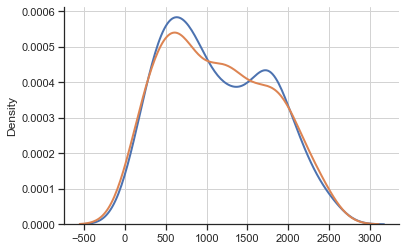

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_actg_dataset()
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
# X, y, features, categ, sch_nan = ds.load_wuhan_dataset()

qs = np.quantile(y["time"], np.linspace(0.2, 0.8, 4))
time_discr = np.searchsorted(qs, y["time"])

discr = np.char.add(time_discr.astype(str), y["cens"].astype(str))
X_TR, X_HO = train_test_split(X, stratify=discr, test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

df_tr = X_tr.copy()
df_tr["time"] = y_tr["time"]
df_tr["cens"] = y_tr["cens"]

sns.kdeplot(y_tr["time"], label="train")
sns.kdeplot(y_HO["time"], label="HO")
plt.show()

### Informative censuring comparison

In [4]:
import survivors.datasets as ds
import survivors.constants as cnt
from survivors.external.nonparametric import KaplanMeier

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
bins_HO = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]

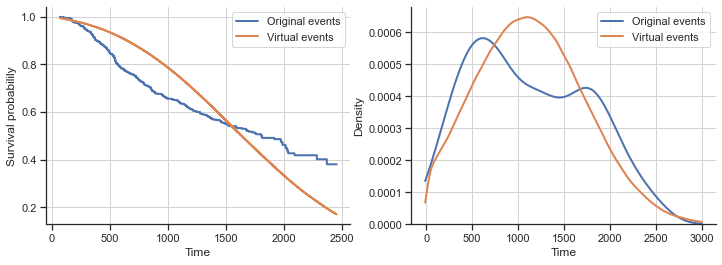

In [5]:
def med_std(x):
    N = len(x)
    d2 = abs(x - np.median(x))**2  # abs is for complex `a`
    var = np.sum(d2) / N  # note use of `ddof`
    return var**0.5

class KaplanMeierZeroAfter(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.array(durations)
        self.events = np.array(right_censor)
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        # place_bin = np.digitize(times, self.timeline)  # -1
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfter1(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.random.normal(np.median(durations), np.std(durations), 1000000)  # / np.sqrt(2)
        self.events = np.random.choice(right_censor, size=1000000, replace=True)
        self.durs = np.hstack([durations.copy(), self.durs])
        self.events = np.hstack([right_censor.copy(), self.events])
        
#         self.durs = np.random.normal(np.mean(durations), np.std(durations)/np.sqrt(2), 1000)
#         self.events = np.random.choice(right_censor, size=1000, replace=True)

#         self.durs = np.vstack([np.random.choice(durations, size=1000, replace=True), 
#                                np.random.choice(durations, size=1000, replace=True)]).mean(axis=0)
#         self.events = np.random.choice(right_censor, size=1000, replace=True)
        
        self.events = self.events[self.durs > 0]
        self.durs = self.durs[self.durs > 0]
        
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        # place_bin = np.digitize(times, self.timeline)  # -1
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf

y_ = y
X_ = X

km = KaplanMeierZeroAfter()
km.fit(y_["time"], y_["cens"])
sf = km.survival_function_at_times(bins_HO)

km1 = KaplanMeierZeroAfter1()
km1.fit(y_["time"], y_["cens"])
sf1 = km1.survival_function_at_times(bins_HO)

# ibs_sf = metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
# ibs_sf1 = metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

# auprc_sf = metr.auprc(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
# auprc_sf1 = metr.auprc(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].step(bins_HO, sf, label="Original events")
axes[0].step(bins_HO, sf1, label="Virtual events")
axes[0].legend()

sns.kdeplot(km.durs, ax=axes[1], label="Original events", clip=[-10, 3000])
sns.kdeplot(km1.durs, ax=axes[1], label="Virtual events", clip=[-10, 3000])
axes[1].legend()

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Survival probabilily")
axes[1].set_xlabel("Time")
# print(f"SF IBS:{ibs_sf:.5f}, AUPRC:{auprc_sf:.5f}")
# print(f"SF1 IBS:{ibs_sf1:.5f}, AUPRC:{auprc_sf1:.5f}")
plt.savefig('./GBSG_MULTI_KM_DENS_NORM.png', dpi=300, bbox_inches='tight')

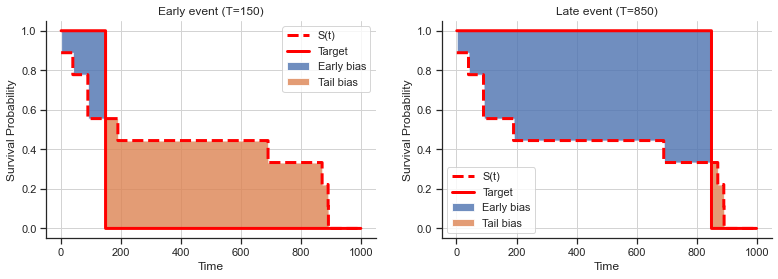

In [6]:
def split_time_to_bins(time, event=None, apr_times=None, apr_events=None):
    if apr_times is None:
        return np.searchsorted(np.arange(int(time.min() - 1), int(time.max() + 1)), time)
    return np.searchsorted(np.arange(int(apr_times.min() - 1), int(apr_times.max() + 1)), time)

def get_sa_hists(time, cens, minlength=1, weights=None):
    if time.shape[0] > 0:
        time_hist = np.bincount(time, minlength=minlength)
        cens_hist = np.bincount(time, weights=cens, minlength=minlength)
    else:
        time_hist, cens_hist = np.array([]), np.array([])
    return time_hist, cens_hist

def plot_event_with_sf(bins, sf, e_time, ax, has_label=True):
    if not(bins is None):
        ax.step(bins, sf, color="red", linestyle="--", linewidth=3, label="S(t)")
    ind_early = np.where(bins < e_time)[0]
    ind_late = np.where(bins >= e_time)[0]
    ax.step(bins, np.hstack([np.ones_like(ind_early), np.zeros_like(ind_late)]), linewidth=3, color="red", label="Target")
    ax.fill_between(bins[ind_early], sf[ind_early], 1, alpha=0.8, label="Early bias") 
    ax.fill_between(bins[ind_late], sf[ind_late], 0, alpha=0.8, label="Tail bias")  # , hatch = '/')
    ax.set_ylabel("Survival Probability")
    ax.set_xlabel("Time")
    # ax.set_ylabel("Вероятность выживания", fontsize=16, fontname="Times New Roman")
    # if has_label:
        # ax.set_xlabel("Время", fontsize=16, fontname="Times New Roman")
    ax.legend()

def visualize_filled(time, cens, bins=None):
    if bins is None:
        bins = np.arange(time.min() - 1, time.max())
    t1 = split_time_to_bins(time, bins)
    bins1 = split_time_to_bins(bins, bins)
    max_bin = bins1.max()
    time_hist, cens_hist = get_sa_hists(t1, cens, minlength=max_bin + 2)
    
    c_time = np.cumsum(time_hist[::-1])[::-1]
    sf = np.cumprod((1.0 - cens_hist / (c_time + 1)))
    sf[c_time == 0] = 0.0
    
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))
    plot_event_with_sf(bins, sf[1:-1], 150, axes[0], has_label=False)
    plot_event_with_sf(bins, sf[1:-1], 850, axes[1])
    axes[0].set_title(f"Early event (T={150})")
    axes[1].set_title(f"Late event (T={850})")
    # axes[0].set_title(f"Ранее событие (T={150})", fontsize=16, fontname="Times New Roman")
    # axes[1].set_title(f"Позднее событие (T={850})", fontsize=16, fontname="Times New Roman")
    #plt.show()
    
a = np.array([10, 50, 100, 100, 200, 700, 880, 900])
visualize_filled(a, np.ones_like(a), np.arange(1, 1000))
plt.savefig('./InterpretEarlyLate.png', dpi=300, bbox_inches='tight')